In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [76]:
DIR = "~/.kaggle/competitions/competitive-data-science-final-project/"
sales = pd.read_csv(DIR+'sales_train.csv.gz')
shops = pd.read_csv(DIR+'shops.csv')
items = pd.read_csv(DIR+'items.csv')
item_cats = pd.read_csv(DIR+'item_categories.csv')
tests = pd.read_csv(DIR+'test.csv.gz').drop("ID",axis=1)
samples = pd.read_csv(DIR+'sample_submission.csv.gz')

In [77]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [80]:
sales = pd.read_csv(DIR+'sales_train_processed.csv')

In [81]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday
0,2013-02-15,1,0,30,265.00,2.0,4
1,2013-02-16,1,0,30,265.00,9.0,5
2,2013-02-17,1,0,30,265.00,4.0,6
3,2013-02-18,1,0,30,265.00,4.0,0
4,2013-02-20,1,0,30,265.00,2.0,2
5,2013-02-21,1,0,30,265.00,2.0,3
6,2013-02-22,1,0,30,265.00,2.0,4
7,2013-02-23,1,0,30,265.00,3.0,5
8,2013-02-26,1,0,30,265.00,3.0,1
9,2013-02-15,1,0,31,434.00,3.0,4


In [ ]:
from datetime import datetime as dt

In [ ]:
sales.date = sales.date.apply(lambda x: dt.strptime(x, '%d.%m.%Y'))

In [ ]:
sales["weekday"] = sales.date.apply(lambda x: x.weekday())

In [ ]:
sales.groupby("date")["item_cnt_day"].sum().plot(figsize=(15,7))

In [ ]:
sales.groupby("weekday")["item_cnt_day"].sum()

In [ ]:
# remove roll back item
sales = sales.sort_values(["shop_id","item_id","date"]).reset_index(drop=True)
for ind in tqdm_notebook(sales[sales.item_cnt_day<0].index):
    sales_one = sales.loc[ind]
    shop_id = sales_one.shop_id
    flag=ind-1
    while(flag):
        if (sales.loc[flag].item_id != sales_one.item_id) or (sales.loc[flag].shop_id != sales_one.shop_id):
            break
        if sales.loc[flag].item_cnt_day >= -1 * sales_one.item_cnt_day:
            sales.loc[flag , "item_cnt_day"] += sales_one.item_cnt_day
            sales.loc[ind, "item_cnt_day"] = 0
            break
        flag -= 1

In [ ]:
# remove other 0
sales[sales.item_cnt_day<0] = 0 

In [57]:
sales.to_csv(DIR+'sales_train_processed.csv',index=None)

In [58]:
# Create "grid" with columns
# date block num means the order of month
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates: vars
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'var'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates: vars
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'var'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [59]:
#gb = sales.groupby(['date_block_num'],as_index=False).agg({'weekday':'count'}) # sum 'item_cnt_day'

In [60]:
# concat test data
tests["date_block_num"] = 34
tests["target"] = np.nan
tests["target_shop"] = np.nan
tests["target_item"] = np.nan
all_data = pd.concat([all_data, tests],axis=0)

In [61]:
# mean encoding
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id')['target'].cumcount()
all_data['item_target_enc'] = cumsum /cumcnt
all_data['item_target_enc'].fillna(0.3343, inplace=True) 

In [73]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

#  weekday features
a = sales.groupby(["date", "date_block_num", "weekday"]).count().reset_index()[["date", 
                                                                            "date_block_num", "weekday"]].groupby(["date_block_num","weekday"]).size().reset_index()
b = pd.get_dummies(a["weekday"])
b.columns=["weekday_"+str(i) for i in range(7)]
b = b*np.tile(a[0].values.reshape(-1, 1),7)
a = pd.concat([a,b],axis=1).drop(["weekday", 0], axis=1).groupby("date_block_num").sum().reset_index()

all_data = pd.merge(all_data, a, on='date_block_num')

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 

# We will drop these at fitting stage
# for avoid dataleakage
# to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] - ['weekday_0',  'weekday_6']

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

KeyError: "['item_target_enc_lag_1' 'target_item_lag_1' 'target_item_x_lag_1'\n 'target_item_y_lag_1' 'target_lag_1' 'target_shop_lag_1'\n 'target_shop_x_lag_1' 'target_shop_y_lag_1'] not in index"

In [ ]:
to_drop_cols

### train, validate scheme

In [74]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max() # for validation data: last block is test data to predict
print('Test `date_block_num` is %d' % last_block)

test_rate = 0.25
train_rate = 1 - test_rate
dates_train = dates[dates <  (last_block - 2)]
dates_val = dates[dates == (last_block - 2)]
dates_test = dates[dates == (last_block - 1)]
dates_submit  = dates[dates == last_block]

X_train = all_data.loc[dates <  (last_block - 2)].drop(to_drop_cols, axis=1)
X_val = all_data.loc[dates == (last_block - 2)].drop(to_drop_cols, axis=1)
X_test = all_data.loc[dates == (last_block - 1)].drop(to_drop_cols, axis=1)
X_submit =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  (last_block - 2), 'target'].values
y_val = all_data.loc[dates == (last_block - 2), 'target'].values
y_test = all_data.loc[dates == (last_block - 1), 'target'].values
y_submit =  all_data.loc[dates == last_block, 'target'].values

Test `date_block_num` is 33


In [75]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':2, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train),  # it is better not to clip train data
                  num_boost_round=20)
pred = model.predict(X_val)

print('Test R-squared for LightGBM is %f' % r2_score(y_val.clip(0,20), pred.clip(0,20)))
print('Valid RMSE is %f' % np.sqrt(mean_squared_error(y_val.clip(0,20), pred.clip(0,20))))
print('Test RMSE is %f' % np.sqrt(mean_squared_error(y_test.clip(0,20), model.predict(X_test).clip(0,20))))

KeyboardInterrupt: 

Test R-squared for LightGBM is 0.326516
Valid RMSE is 0.871942
Test RMSE is 0.971040

Test R-squared for LightGBM is 0.326477
Valid RMSE is 0.871968
Test RMSE is 0.971562

Test R-squared for LightGBM is 0.321752
Valid RMSE is 0.875138
Test RMSE is 0.976434

Test R-squared for LightGBM is 0.291365
Valid RMSE is 0.971616
Test RMSE is 1.001099

In [44]:
lgb.train?

In [11]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.253475


In [12]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.282812


In [13]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 

In [14]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [15]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

ind=0
# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    X_train_level1 = X_train.loc[dates_train[dates_train<cur_block_num].index]
    y_train_level1 = y_train[dates_train[dates_train<cur_block_num].index]
    lr.fit(X_train_level1, y_train_level1)
    model = lgb.train(lgb_params, lgb.Dataset(X_train_level1, label=y_train_level1), 100)
    
    Xtr = X_train.loc[dates_train_level2[dates_train_level2==cur_block_num].index].values
    X_train_level2[ind:ind+len(Xtr),0] = lr.predict(Xtr)
    X_train_level2[ind:ind+len(Xtr),1] = model.predict(Xtr)
    ind += len(Xtr)
    

27
28
29
30
31
32


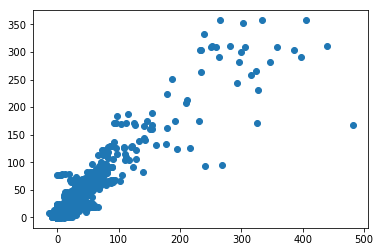

In [16]:
plt.scatter(X_train_level2[:,0],X_train_level2[:,1])

In [36]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_mix = 0
r2_alpha = 0
for alpha in tqdm_notebook(alphas_to_try):
    pred = alpha * X_train_level2[:, 0] + (1 - alpha) * X_train_level2[:, 1]
    score = r2_score(y_train_level2, pred)
    if (score > r2_mix):
        r2_mix = score
        r2_alpha = alpha

# YOUR CODE GOES HERE
best_alpha = r2_alpha
r2_train_simple_mix = r2_mix

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))


Best alpha: 0.160000; Corresponding r2 score on train: 0.269077


In [35]:
test_preds = best_alpha * X_test_level2[:, 0] + (1 - best_alpha) * X_test_level2[:, 1]
r2_test_simple_mix = r2_score(y_test, test_preds)

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)
print('Test RMSE for simple mix is %f' % np.sqrt(mean_squared_error(y_test, test_preds)))

Test R-squared for simple mix is 0.046454
Test RMSE for simple mix is 5.217169


In [33]:
test_preds.clip(0.,20.)

array([ 0.07576708,  0.79576669,  0.59885192, ...,  0.20857642,
        0.0757175 ,  0.04681406])

### for submission

In [19]:
samples.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [20]:
X_submit =  all_data.loc[dates == last_block+1].drop(to_drop_cols, axis=1)

# first layer
pred_lr = lr.predict(X_submit.values).clip(0.,20.)
pred_lgb = model.predict(X_submit).clip(0.,20.)

# second layer
X_submit_level2 = np.c_[pred_lr, pred_lgb] 
submit_preds = best_alpha * X_submit_level2[:, 0] + (1 - best_alpha) * X_submit_level2[:, 1] # ensemble

# transform submission form
submit_cols = ["ID", "item_cnt_month"]
submit = pd.DataFrame(np.c_[np.arange(len(submit_preds)).astype("int"),submit_preds.clip(0.,20.)], columns=submit_cols)

In [21]:
submit.to_csv("csv/baseline_with_mean_enc.csv",index=None)

In [30]:
submit.item_cnt_month.sort_values()

187633     -0.640772
208033     -0.570742
34633      -0.538166
157033     -0.488156
136633     -0.399540
116233     -0.399079
157058     -0.282483
111133     -0.276268
154140     -0.273256
153682     -0.258793
24433      -0.232048
9133       -0.231865
19333      -0.231711
148341     -0.231112
184907     -0.230750
65258      -0.227616
174707     -0.217894
169607     -0.215458
186714     -0.212957
9158       -0.203600
153441     -0.195844
149040     -0.192244
19358      -0.190439
187521     -0.189052
154307     -0.187711
187658     -0.186922
122841     -0.182421
4058       -0.182084
108407     -0.181857
185146     -0.181837
183801     -0.181811
183799     -0.181811
149207     -0.181751
153099     -0.179396
158541     -0.177607
187578     -0.176514
183604     -0.176377
153956     -0.176293
113507     -0.173539
184041     -0.173293
197858     -0.171726
112641     -0.170038
15741      -0.169373
116258     -0.164365
184556     -0.159052
187873     -0.158855
118607     -0.158172
157273     -0